<a href="https://colab.research.google.com/github/Gabrielvss/bert_tpu_finetuning/blob/main/TPU_LM_TRAIN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🖇️ Introduction

This is a pipeline for training language models on TPU, with the following main advantages:

* **Time speedup:** Training on TPU is significantly faster compared to GPU, especially in free environments like Colab and Kaggle.

* **Memory (OOM):** It's possible to train with more samples, larger batch sizes, and higher dimensions for embeddings.

* This pipeline is focused on language models (LM) rather than large language models (LLM), such as the BERT family (BERT, RoBERTa, DistilBERT). This means it doesn't use adapters or PEFT.

For comparison, in a Kaggle GPU kernel using 2x T4 (~30GB), each epoch takes about 50 minutes with ~10k samples in the training set. Here, on TPU, I used 39k samples, and each epoch takes just 0.71 minutes.







# 📄 Librarys  and Packeges


In [ ]:
# !pip install -q  datasets
# !pip install -q transformers==4.37.2
# !pip install -qU wandb

In [ ]:
#Data Manipulation
import pandas as pd
import numpy as np
from scipy.special import softmax
import math
import yaml

#plots
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


# #Hugingface
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import  TFDistilBertModel
import transformers
from datasets import load_dataset,Dataset, DatasetDict

# #Torch
import torch

# #Keras and Tensorflow
import keras
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model
from keras.callbacks import Callback


# #Sklearn
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.manifold import TSNE

# #General utils
from string import punctuation
import json
import random
import os
from tqdm.notebook import tqdm
import time

# #tensorflow sets
# tf.get_logger().setLevel('ERROR')
# # Set autograph verbosity to avoid unnecessary messages
# tf.autograph.set_verbosity(0)
# # Enable xla for speed up
# tf.config.optimizer.set_jit(True)


print('transformers', transformers.__version__)
print('tensorflow', tf.__version__)
print('keras', keras.__version__)
print('torch', torch.__version__)

transformers 4.37.2
tensorflow 2.15.0
keras 2.15.0
torch 2.4.0+cpu


In [ ]:
# transformers 4.37.2
# tensorflow 2.15.0
# keras 2.15.0
# torch 2.4.0+cpu

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ⚙️ Configuarations


In [ ]:
class CFG:
    seed = 42
    model_name ='roberta-base' #"distilbert-base-uncased", google-bert/bert-base-cased, roberta-base
    batch_size = 32
    device = 'TPU-VM'
    replicas = 0

    data = '/content/drive/MyDrive/TrilhaML/NLP/LLM/FineTuning/TPU/all_tickets_processed_improved_v3.csv'
    test_size = 0.2

    debug = False
    wandb = True
    epochs = 1 if debug else 5
    lr = 1e-4
    optimizer = 'Adam'
    loss =  'categorical_crossentropy' #'categorical_crossentropy', focal_loss
    smoothing = 0.2
    model_path = './finetuning_chkp'
    scheduler = 'cosine'#cosine, exp
    dropout = 0.1
    n_classes = 8

    gamma = 3.0
    alpha = 0.25



    max_len = 512
    auto = tf.data.experimental.AUTOTUNE


## Color

Notebook Color Schemes:


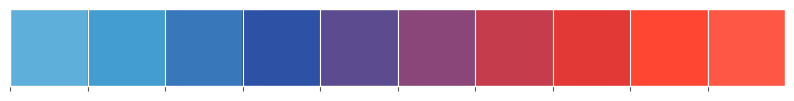

In [ ]:
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'
    R = '\033[31m'
    G = '\033[1;32m'
    Y = '\033[33m'

my_colors = ["#5EAFD9", "#449DD1", "#3977BB",
             "#2D51A5", "#5C4C8F", "#8B4679",
             "#C53D4C", "#E23836", "#FF4633", "#FF5746"]
CMAP1 = ListedColormap(my_colors)

plt.style.use('ggplot')

print(clr.S+"Notebook Color Schemes:"+clr.E)
sns.palplot(sns.color_palette(my_colors))
plt.show()

# Wandb

For set Wandb add your key to secrets with name `WANDB_KEY`

In [ ]:
from google.colab import userdata
import wandb

try:
  api_key = userdata.get('WANDB_KEY')
  wandb.login(key=api_key)
  anonymous = None
except:
  anonymous = 'anonymous'


wandb: Currently logged in as: gvinicius178 (pidgeys). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# 🔧 Utils

## General Utils

In [ ]:
def inference_one_sample(sample, model):
    tokenizer_text = tokenizer(sample, return_tensors='tf')#.to(device)
    model = model#.to(device)
    logits = model(**tokenizer_text)
    probs = tf.keras.layers.Softmax()(logits[0][0])
    probs = probs.numpy()
    #print('Shape of Tokenizer: ', tokenizer_text['input_ids'].shape)
    out = {'neg':probs[0],'neu':probs[1], 'pos': probs[2]}
    return out

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

#source: https://www.kaggle.com/code/awsaf49/birdclef23-pretraining-is-all-you-need-train
def get_device():
    "Detect and intializes GPU/TPU automatically"
    # Check TPU category
    tpu = 'local' if CFG.device=='TPU-VM' else None
    try:

        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.TPUStrategy(resolver)
        print(f'> Running on {CFG.device} ', resolver.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device=CFG.device
    except:
        # If TPU is not available, detect GPUs
        gpus = tf.config.list_logical_devices('GPU')
        ngpu = len(gpus)
         # Check number of GPUs
        if ngpu:
            # Set GPU strategy
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            # Print GPU details
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            # If no GPUs are available, use CPU
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy()
            device='CPU'
    return strategy, device, tpu

def create_StratifiedKfolds(df):

    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=CFG.seed)

    # Reset the index of the dataframe
    df = df.copy().reset_index(drop=True)

    # Create a new column in the dataframe to store the fold number for each row
    df["fold"] = [-1 for i in range(len(df))]

    # Iterate over the folds and assign the corresponding fold number to each row in the dataframe
    for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['labels'])):
        df.loc[val_idx, 'fold'] = fold

    return df

def tokenizer_data(batch):
    '''Reshape text-ids vect to max_lenght'''
    tokenized_data = tokenizer(batch['text'],
                             #return_tensors="np",
                             padding= 'max_length',
                             truncation=True,
                             max_length = CFG.max_len
                            )

    return tokenized_data


def wandb_init():
    config = {k:v for k,v in dict(vars(CFG)).items() if '__' not in k}
    yaml.dump(config, open(f'/.{CFG.model_name}_config.yaml', 'w'),)
    config = yaml.load(open(f'/.{CFG.model_name}_config.yaml', 'r'), Loader=yaml.FullLoader)
    run    = wandb.init(project="IT-tickets-classification",
               name=f"{CFG.model_name}_EP_{CFG.epochs}_{CFG.loss}_SM_{CFG.smoothing}",
               config=config,
               anonymous=anonymous,
               group=CFG.model_name
              )
    return run

def log_wandb():
    "log best result for error analysis"
    # log values to wandb
    wandb.log({
               'best_acc': best_acc,
               'best_loss': best_loss,
               'best_epoch': best_epoch,
               'best_acc_bowel': best_acc_bowel,
               'best_acc_extra': best_acc_extra,
               'best_acc_liver': best_acc_liver,
               'best_acc_kidney': best_acc_kidney,
               'best_acc_spleen': best_acc_spleen,
              })

def get_wb_callbacks():
    wb_ckpt = wandb.keras.WandbModelCheckpoint(filepath='model.h5',
                                               monitor='val_loss',
                                               verbose=True,
                                               save_best_only=False,
                                               save_weights_only=False,
                                               mode='min',)
    wb_metr = wandb.keras.WandbMetricsLogger()
    return [wb_ckpt, wb_metr]

## Model Utils

In [ ]:
# def focal_loss(gamma=2.0, alpha=0.25):
#     """
#     Focal Loss for binary classification.

#     Parameters:
#         gamma: focusing parameter, default is 2.0.
#         alpha: balancing factor, default is 0.25.

#     Returns:
#         loss: computed focal loss.
#     """
#     def focal_loss_fixed(y_true, y_pred):
#         # Clip predictions to prevent log(0)
#         y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

#         # Calculate cross entropy
#         cross_entropy = -y_true * K.log(y_pred)

#         # Calculate focal loss components
#         loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

#         return K.mean(K.sum(loss, axis=-1))

#     return focal_loss_fixed

In [ ]:


def get_loss():

    if CFG.loss == 'sparse_categorical_crossentropy':
        loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    elif CFG.loss == 'binary_crossentropy':
        loss= tf.keras.losses.BinaryCrossentropy(from_logits=False)
    elif CFG.loss == 'categorical_crossentropy':
        loss= tf.keras.losses.CategoricalCrossentropy(from_logits=False,
                                                      label_smoothing = CFG.smoothing)
    elif CFG.loss == 'focal_loss':
        loss = tf.keras.losses.CategoricalFocalCrossentropy(gamma=CFG.gamma,
                                                            alpha=CFG.alpha,
                                                            from_logits=False,
                                                            label_smoothing = CFG.smoothing)
        #loss= focal_loss(gamma=CFG.gamma, alpha=CFG.alpha)
    else:
        print('Invalid Loss input')

    return loss

def get_optimizer():
    if CFG.optimizer == 'Adam':
        op= tf.keras.optimizers.legacy.Adam(learning_rate=CFG.lr)
    elif CFG.optimizer == 'AdamW':
        op= tf.keras.optimizers.AdamW(learning_rate=CFG.lr)
    else:
        print('Invalid Loss input')

    return op


def build_model():

    transfomer_layer = transformers.TFBertModel\
       .from_pretrained(CFG.model_name)


    input_ids = Input(shape=(CFG.max_len,),
                      name='input_ids',
                      dtype = tf.int32)

    mask = Input(shape=(CFG.max_len,),
                 name='attention_mask',
                 dtype = tf.int32)

    x = transfomer_layer(input_ids=input_ids,
                   attention_mask=mask)

    x = tf.keras.layers.Flatten()(x[0])

    out = tf.keras.layers.Dense(3, activation = 'softmax')(x)

    model = tf.keras.Model(inputs=[mask , input_ids], outputs=out)

    optimizer = get_optimizer()
    loss = get_loss()
    model.compile(loss = loss, optimizer = optimizer)

    return model


def cosine_decay(plot=False, initial_lr=CFG.lr, total_epochs=CFG.epochs):
    def lr_fn(epoch):
        lr = 0.5 * initial_lr * (1 + np.cos(np.pi * epoch / total_epochs))
        return lr
    lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_fn, verbose=True)
    if plot:
        plt.figure(figsize=(10,5))
        plt.plot(np.arange(CFG.epochs), [lr_fn(epoch) for epoch in np.arange(CFG.epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
        plt.show()
    return lr_callback



def plot_history(history):
    fig, ax = plt.subplots(figsize = (15,7))

    epochs = np.arange(CFG.epochs)
    results = history.history

    ax.plot(epochs, results['loss'], marker='o', label = 'train_loss')
    ax.plot(epochs, results['val_loss'], marker='o', label = 'val_loss')

    ax.legend()

    plt.suptitle('Loss History', fontsize = 20)
    ax.set_title('Loss', fontsize=16)
    plt.show()



class SaveModelCallback(Callback):
    def __init__(self, save_dir=CFG.model_path, save_every=1):
        super(SaveModelCallback, self).__init__()
        self.save_dir = save_dir
        self.save_every = save_every
        self.epoch_counter = 0

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_counter += 1
        if self.epoch_counter % self.save_every == 0:
            model_filename = f"model_epoch_{self.epoch_counter}"
            model_path = os.path.join(self.save_dir, model_filename)
            self.model.save_pretrained(model_path)

class TimeCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        epoch_time = epoch_time/60
        print(f" Epoch time: {epoch_time:.2f}min")

# 💻 Device and Seed

Colab free TPUs are a V2 version and have 8 devices.

In [ ]:
strategy, CFG.device, tpu = get_device()
CFG.replicas = strategy.num_replicas_in_sync

> Running on TPU-VM   | Num of TPUs:  8


In [ ]:
set_seed(CFG.seed)

# 📒 Data

This is a [IT Service Ticket Classification Dataset](https://www.kaggle.com/datasets/adisongoh/it-service-ticket-classification-dataset/data).

* There is a Multiclass problem (softmax)

In [ ]:
df = pd.read_csv(CFG.data)
label_dict = {
    'Hardware': 0,
    'Access': 1,
    'Miscellaneous': 2,
    'HR Support': 3,
    'Purchase': 4,
    'Administrative rights': 5,
    'Storage': 6,
    'Internal Project': 7,

}

df['labels'] = df['Topic_group'].map(label_dict)



X, y = df['Document'], df['labels']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=CFG.test_size, random_state=CFG.seed)

train = pd.DataFrame({'text': X_train, 'labels':y_train})

train['group'] = train.groupby('labels').cumcount()
train = train.sort_values(by=['group', 'labels']).reset_index(drop = True)
train = train.drop('group', axis = 1)

test = pd.DataFrame({'text': X_test, 'labels':y_test}).reset_index(drop = True)




train.head(10)

,text,labels
0,dashboard import issues sent wednesday re dash...,0
1,suspect message do not open block user tuesday...,1
2,change line manager for oracle issue sent chan...,2
3,oracle error sent wednesday error hi please be...,3
4,po wednesday pm hi pro retina intel has arrive...,4
5,pas and asp changes oracle tuesday november pm...,5
6,urgent need external folder set up thursday ju...,6
7,new project required tuesday pm required dear ...,7
8,event notification sub door remote alarm origi...,0
9,issues with issues with hello last week change...,1


## Tokenizer

In [ ]:
tokenizer  = AutoTokenizer.from_pretrained(CFG.model_name, return_tensors='tf')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def get_n_tokens(text):
  tokens = tokenizer.tokenize(text)
  num_tokens = len(tokens)
  return num_tokens


df['n_tokens'] = df['Document'].apply(get_n_tokens)
df['n_chars'] = df['Document'].apply(lambda x: len(x))

train['n_tokens'] = train['text'].apply(get_n_tokens)
test['n_tokens'] = test['text'].apply(get_n_tokens)

Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors


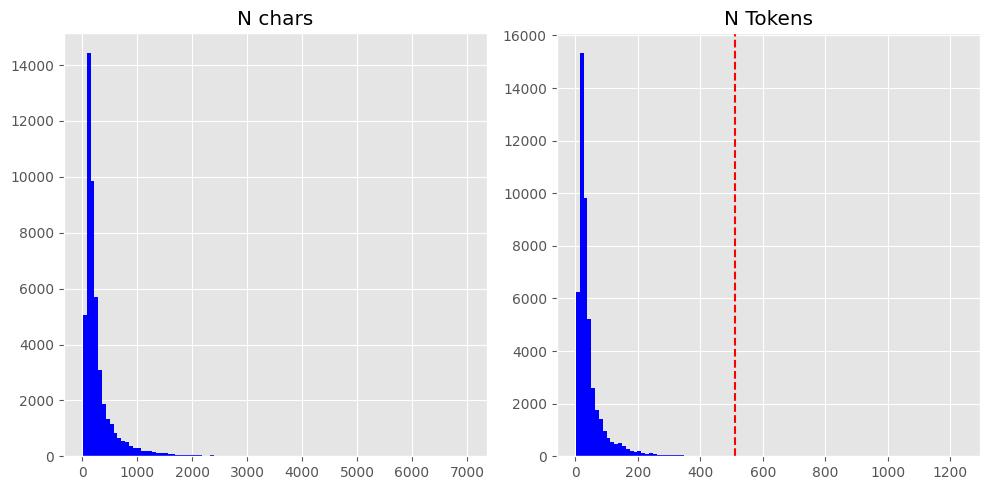

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15, 5))

df['n_chars'].hist(figsize=(10, 5), bins=100, ax=ax[0], color = 'blue')
df['n_tokens'].hist(figsize=(10, 5), bins=100, ax=ax[1], color = 'blue')

ax[0].set_title('N chars')
ax[1].set_title('N Tokens')
ax[1].axvline(x=512, color='red', linestyle='--')
plt.tight_layout()
plt.show()

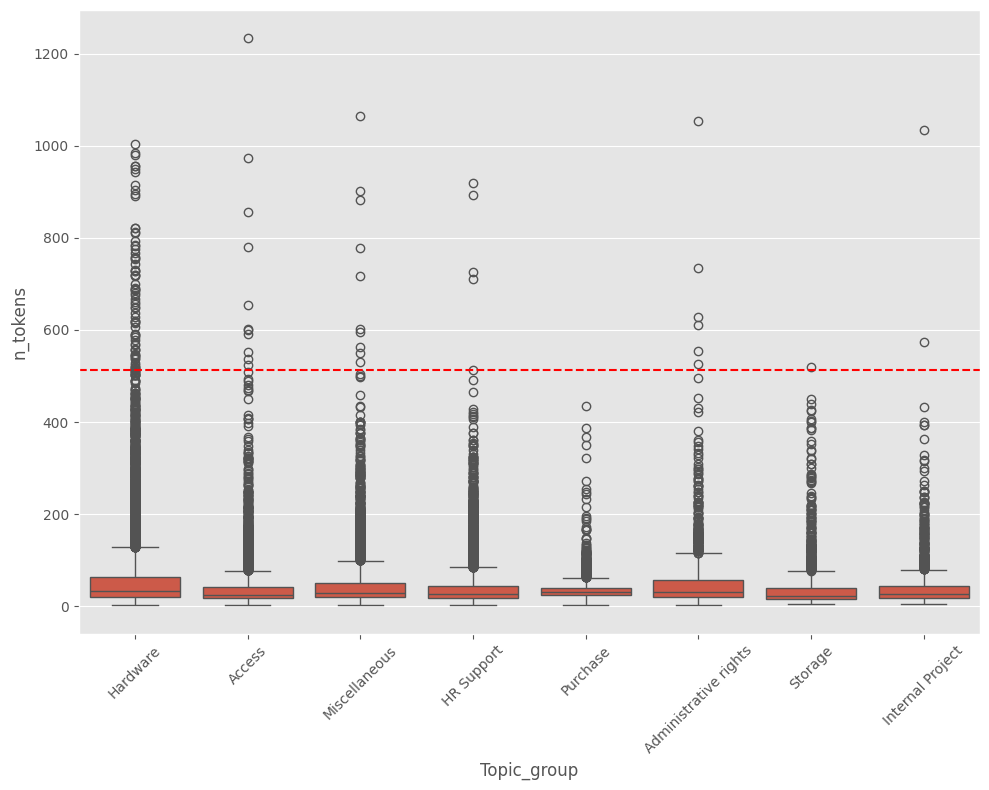

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='Topic_group', y = 'n_tokens')
ax.axhline(y=512, color='red', linestyle='--')
ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df['Document'][df['n_tokens'] > 512].iloc[0]

'install module new router re critical peer session down hello about module replacement after everything mounted back powered thank engineer friday re critical peer session down shipping replacement router arrive unfortunately hardware known faulty problem module called inside router needs moved dead router router feel comfortable steps module dead router install let figure out visit site handle installation run router without part good install rack re rack again thanks motherboard step turn off electrical router leave cable plugged channel voltages ground step router cover step locate motherboard figure figure location content renditions screws connector standoffs step loosen screws step lift motherboard step static bag step replace cover install motherboard series install step warnings section disconnect replace module step turn off electrical router leave cable plugged channel voltages ground step cover step identify slot router main motherboard step locate standoffs motherboard fig

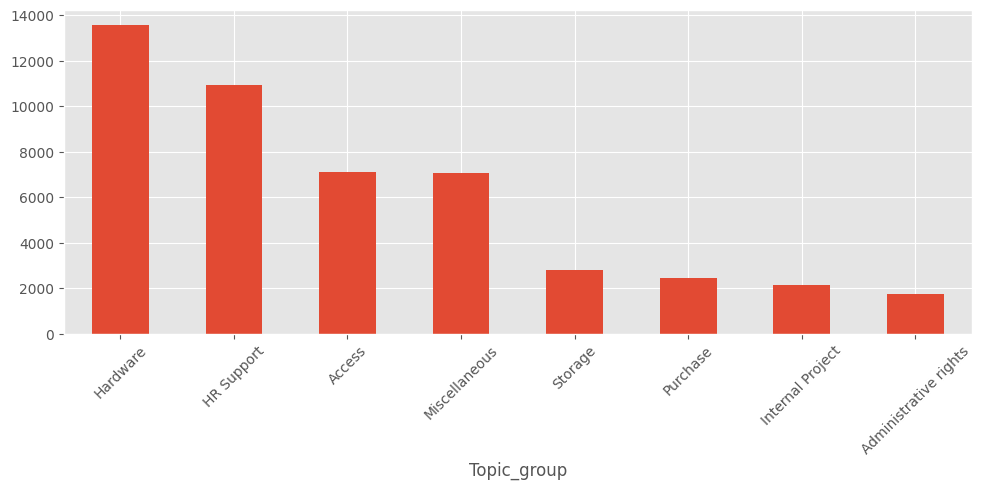

In [ ]:
df.loc[df['n_tokens'] <= 512,'Topic_group'].value_counts().plot(kind='bar', rot = 45, figsize=(10, 5))
plt.tight_layout()
plt.show()

In [ ]:
train =train.loc[train['n_tokens'] <= 512,:]
test = test.loc[test['n_tokens'] <= 512,:]

if CFG.debug:
    min_samples = CFG.batch_size*CFG.replicas*2

    train = train[:min_samples]
    test = test[:min_samples]

print(train.shape, test.shape)

(38188, 3) (9543, 3)


## Dataset

It's created a dataset with model inputs (tokenized data) and labels in One Encode format.

In [ ]:
train.loc[:,'labels_2'] = pd.get_dummies(train['labels']).values.tolist()
test.loc[:,'labels_2'] = pd.get_dummies(test['labels']).values.tolist()
test.head()

<ipython-input-21-756be06040d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.loc[:,'labels_2'] = pd.get_dummies(train['labels']).values.tolist()
<ipython-input-21-756be06040d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:,'labels_2'] = pd.get_dummies(test['labels']).values.tolist()


,text,labels,n_tokens,labels_2
0,issue with server process sent tuesday issue w...,0,25,"[True, False, False, False, False, False, Fals..."
1,new purchase po wednesday february purchase po...,4,29,"[False, False, False, False, True, False, Fals..."
2,oracle pas urgent re we updated rights query h...,0,39,"[True, False, False, False, False, False, Fals..."
3,new starter access thursday pm re starter form...,3,38,"[False, False, False, True, False, False, Fals..."
4,new phone phone hi taken work mobile phone spe...,0,11,"[True, False, False, False, False, False, Fals..."


In [ ]:
#Create Dict Dataset
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors='tf')


# create HF Dataset from PD dataframe
#source: https://discuss.huggingface.co/t/from-pandas-dataframe-to-huggingface-dataset/9322/4
train_dataset = Dataset.from_pandas(train[['text','labels_2']])
test_dataset = Dataset.from_pandas(test[['text','labels_2']])

ds_dict = DatasetDict()

ds_dict['train'] = train_dataset
ds_dict['test'] = test_dataset


#Tokenizer all data
#batched = True -> Tokenizer for each batch in train loop
tokenized_data = ds_dict.map(tokenizer_data, batched=True)

Map:   0%|          | 0/38188 [00:00<?, ? examples/s]

Map:   0%|          | 0/9543 [00:00<?, ? examples/s]

In [ ]:
tokenized_data.set_format(type='tensorflow', columns=['input_ids', 'attention_mask', 'labels_2'])

In [ ]:
tokenized_data

DatasetDict({
    train: Dataset({
        features: ['text', 'labels_2', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 38188
    })
    test: Dataset({
        features: ['text', 'labels_2', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 9543
    })
})

# 🤗 Model

## Build Model

In [ ]:
def build_model():

    # transfomer_layer = transformers.TFAutoModelForSequenceClassification\
    #    .from_pretrained(CFG.model_name, from_pt=True)

    transfomer_layer = transformers.TFRobertaModel\
       .from_pretrained(CFG.model_name)


    input_ids = Input(shape=(CFG.max_len,),
                      name='input_ids',
                      dtype = tf.int32)

    mask = Input(shape=(CFG.max_len,),
                 name='attention_mask',
                 dtype = tf.int32)


    base_model_out = transfomer_layer(input_ids=input_ids,
                   attention_mask=mask)

    sentence_embeddings = tf.reduce_mean(base_model_out.last_hidden_state, axis=1)

    x = base_model_out.pooler_output
    x = tf.keras.layers.Dropout(CFG.dropout)(x)

    out = tf.keras.layers.Dense(CFG.n_classes, activation = 'softmax', name='label_output')(x)

    model = tf.keras.Model(inputs=[mask , input_ids],
                           outputs=[out, sentence_embeddings] #output probs and embeddings at same inference
                           )

    optimizer = get_optimizer()
    loss = get_loss()
    model.compile(loss = {'label_output': loss},
                  optimizer = optimizer)

    return model

In [ ]:
model = build_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weight

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_roberta_model (TFRobert  TFBaseModelOutputWithPooli   1246456   ['input_ids[0][0]',           
 aModel)                     ngAndCrossAttentions(last_   32         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

## Learning Rate Scheduler

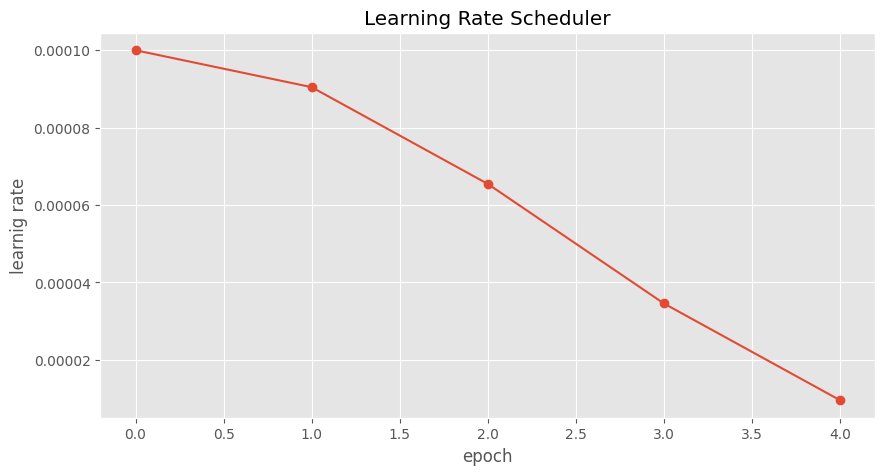

In [ ]:
cosine_decay(initial_lr=CFG.lr, plot = True)

# 💪 Train

Steps:
* 1 - Build Model with strategy (TPU devices)
* 2 - Define Callbacks: Save Checkpoint, Time calculation, Scheduler and Tracker (Wandb)
* 3 - [Convert Hugginface Dataset to Tenforflow dataset](https://huggingface.co/docs/datasets/v2.21.0/en/package_reference/main_classes#datasets.Dataset.to_tf_dataset)
* 4 - Fit model






In [ ]:
CFG.replicas = strategy.num_replicas_in_sync
loss_name = CFG.loss + f' | g = {CFG.gamma} - a = {CFG.alpha}' if CFG.loss == 'focal_loss' else CFG.loss
loss_name+= f' | smoothing = {CFG.smoothing}'
print('Epochs: ', CFG.epochs)
print('Batch Size: ', CFG.batch_size)
print('Steps per Epoch: ', len(train)/CFG.batch_size//CFG.replicas)
print('Loss: ', loss_name)
print('Optimizer: ', CFG.optimizer)



Epochs:  5
Batch Size:  32
Steps per Epoch:  149.0
Loss:  categorical_crossentropy | smoothing = 0.2
Optimizer:  Adam


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

/usr/local/lib/python3.10/dist-packages/datasets/arrow_dataset.py:410: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(



Epoch 1: LearningRateScheduler setting learning rate to 0.0001.
Epoch 1/5
149/149 [==============================] - ETA: 0s - loss: 1.3459 - label_output_loss: 1.3459

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 Epoch time: 2.55min

Epoch 1: saving model to model.h5
149/149 [==============================] - 173s 560ms/step - loss: 1.3459 - label_output_loss: 1.3459 - val_loss: 1.4274 - val_label_output_loss: 1.4274 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.045084971874738e-05.
Epoch 2/5
149/149 [==============================] - ETA: 0s - loss: 1.1633 - label_output_loss: 1.1633 Epoch time: 0.77min

Epoch 2: saving model to model.h5
149/149 [==============================] - 58s 392ms/step - loss: 1.1633 - label_output_loss: 1.1633 - val_loss: 1.3086 - val_label_output_loss: 1.3086 - lr: 9.0451e-05

Epoch 3: LearningRateScheduler setting learning rate to 6.545084971874738e-05.
Epoch 3/5
149/149 [==============================] - ETA: 0s - loss: 1.1140 - label_output_loss: 1.1140 Epoch time: 0.84min

Epoch 3: saving model to model.h5
149/149 [==============================] - 61s 408ms/step - loss: 1.1140 - label_output_loss: 1.1140 - val_loss: 1.2305 - val_l

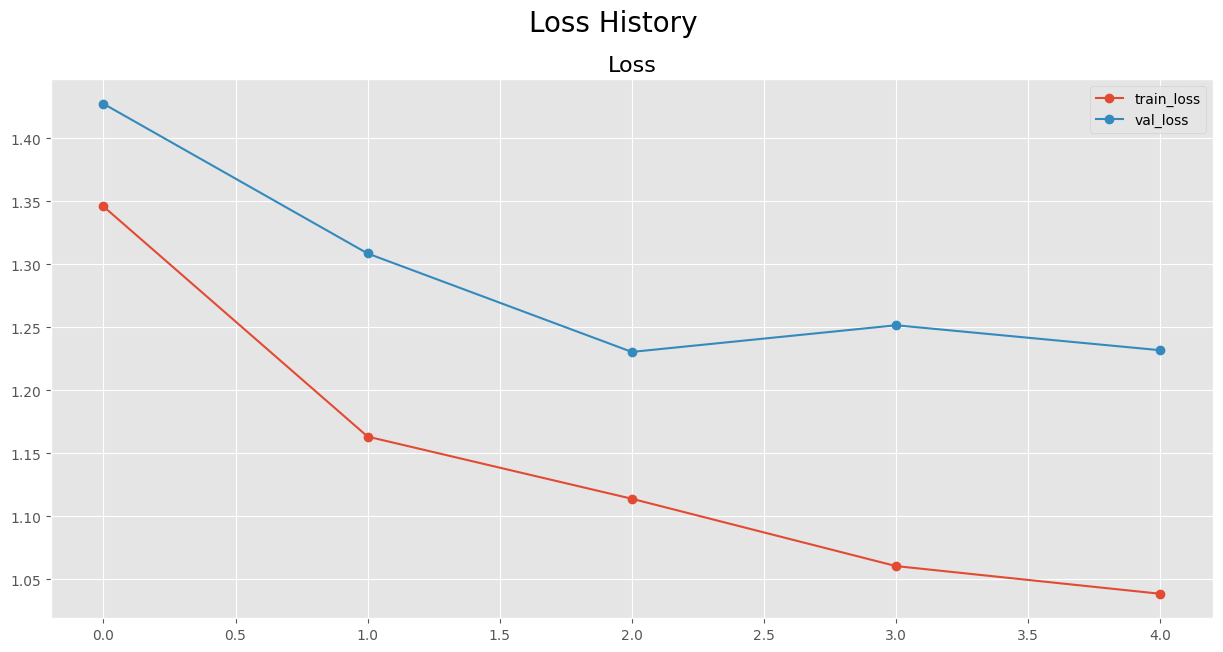

epoch/epoch,▁▃▅▆█
epoch/label_output_loss,█▄▃▂▁
epoch/learning_rate,█▇▅▃▁
epoch/loss,█▄▃▂▁
epoch/lr,█▇▅▃▁
epoch/val_label_output_loss,█▄▁▂▁
epoch/val_loss,█▄▁▂▁
epoch/epoch,4
epoch/label_output_loss,1.03858
epoch/learning_rate,1e-05
epoch/loss,1.03858


In [ ]:
K.clear_session()
with strategy.scope():
    model = build_model()

CFG.replicas = strategy.num_replicas_in_sync

sv =  tf.keras.callbacks.ModelCheckpoint(f"./{CFG.model_name}.h5",
                                         monitor='val_loss',
                                         save_best_only=True,
                                         save_weights_only=False,
                                         save_freq='epoch',
                                         mode = 'min',
                                         verbose = False)
time_callback = TimeCallback()



callbacks = [sv,time_callback,cosine_decay(initial_lr=CFG.lr)]


if CFG.wandb:
    run = wandb_init()
    wb_callbacks = get_wb_callbacks()
    callbacks += wb_callbacks

tf_train_dataset = tokenized_data["train"].to_tf_dataset(
    columns = ['input_ids', 'attention_mask'],
    label_cols = ['labels_2'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = CFG.batch_size,
    #map_fn=map_to_dict,
)



tf_test_dataset = tokenized_data["test"].to_tf_dataset(
    columns = ['input_ids', 'attention_mask'],
    label_cols =['labels_2'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = CFG.batch_size,
    #map_fn=map_to_dict,
)



history = model.fit(tf_train_dataset,
                    epochs = CFG.epochs,
                    callbacks=callbacks,
                    validation_data=tf_test_dataset,
                    steps_per_epoch=len(train)/CFG.batch_size//CFG.replicas,
                    verbose = 1)

plot_history(history)


if CFG.wandb:
  wandb.run.finish()


#Inference

In [ ]:
def get_metrics(y_true_one_hot, scores):

  y_true = np.argmax(y_true_one_hot, axis = 1)
  y_pred = np.argmax(scores, axis = 1)

  f1 = metrics.f1_score(y_true, y_pred, average='macro')
  f1_weight = metrics.f1_score(y_true, y_pred, average='weighted')


  micro_auc = metrics.roc_auc_score(y_true_one_hot,
                                    scores,
                                    average="macro",
                                    multi_class="ovr")

  macro_auc = metrics.roc_auc_score(y_true_one_hot,
                                    scores,
                                    average="micro",
                                    multi_class="ovr")

  print('F1-macro: ', f1)
  print('F1-weighted: ', f1_weight)
  print('Micro AUC: ', micro_auc)
  print('Macro AUC: ', macro_auc)


In [ ]:
model.load_weights('/content/roberta-base.h5')
predictions_probs, embeddings = model.predict(tf_test_dataset)


299/299 [==============================] - 34s 75ms/step


In [ ]:
predictions_probs.shape, embeddings.shape

((9543, 8), (9543, 768))

# Results 🎯

In [ ]:
predictions = np.argmax(predictions_probs, axis= 1)
y_true_one_hot = []
for i in  test['labels']:
  base_arr = np.zeros(CFG.n_classes)
  base_arr[i] = 1
  y_true_one_hot.append(base_arr)

y_true_one_hot = np.array(y_true_one_hot)

get_metrics(y_true_one_hot, predictions_probs)



F1-macro:  0.7198006394305967
F1-weighted:  0.7687742668285334
Micro AUC:  0.9625153079425852
Macro AUC:  0.964327655473686


In [ ]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_true_one_hot, axis = 1)
y_pred = np.argmax(predictions_probs, axis = 1)

c_matrix = confusion_matrix(y_true,y_pred)

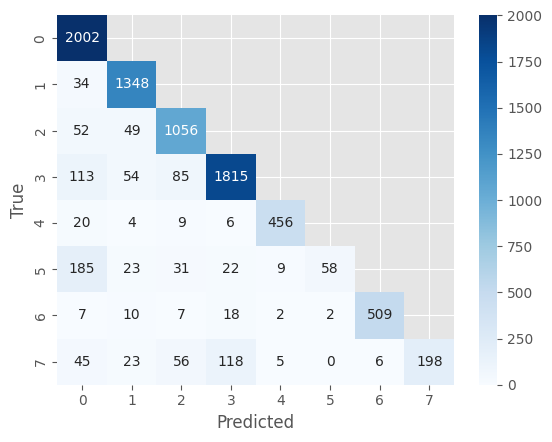

In [ ]:
mask = np.triu(np.ones_like(c_matrix, dtype=bool))
np.fill_diagonal(mask, False)
sns.heatmap(c_matrix,
            mask=mask,
            annot=True,
            fmt='d',
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
print(metrics.classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.73      0.77      2742
           1       0.82      0.93      0.87      1453
           2       0.73      0.76      0.74      1398
           3       0.73      0.86      0.79      2106
           4       0.84      0.92      0.88       497
           5       0.88      0.17      0.29       341
           6       0.74      0.92      0.82       555
           7       0.98      0.44      0.61       451

    accuracy                           0.78      9543
   macro avg       0.82      0.71      0.72      9543
weighted avg       0.79      0.78      0.77      9543



In [ ]:
inverted_dict = {value: key for key, value in label_dict.items()}
normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

two_dim_embeddings = TSNE(
                          n_components=2,
                          learning_rate=200,
                          init='random',
                          perplexity=100,
                          n_iter = 3000,
                          random_state=CFG.seed).fit_transform(normalized_embeddings)

df_plot = pd.DataFrame({'x': two_dim_embeddings[:,0],
                        'y': two_dim_embeddings[:,1],
                        'label': test['labels'].map(inverted_dict),
                        'pred': pd.Series(y_pred).map(inverted_dict).values})

df_plot.head()

,x,y,label,pred
0,-5.395074,20.294462,Hardware,Hardware
1,-78.046715,16.359037,Purchase,Purchase
2,0.325930,25.742065,Hardware,Hardware
3,54.956444,24.930727,HR Support,HR Support
4,-19.473103,42.488682,Hardware,Hardware


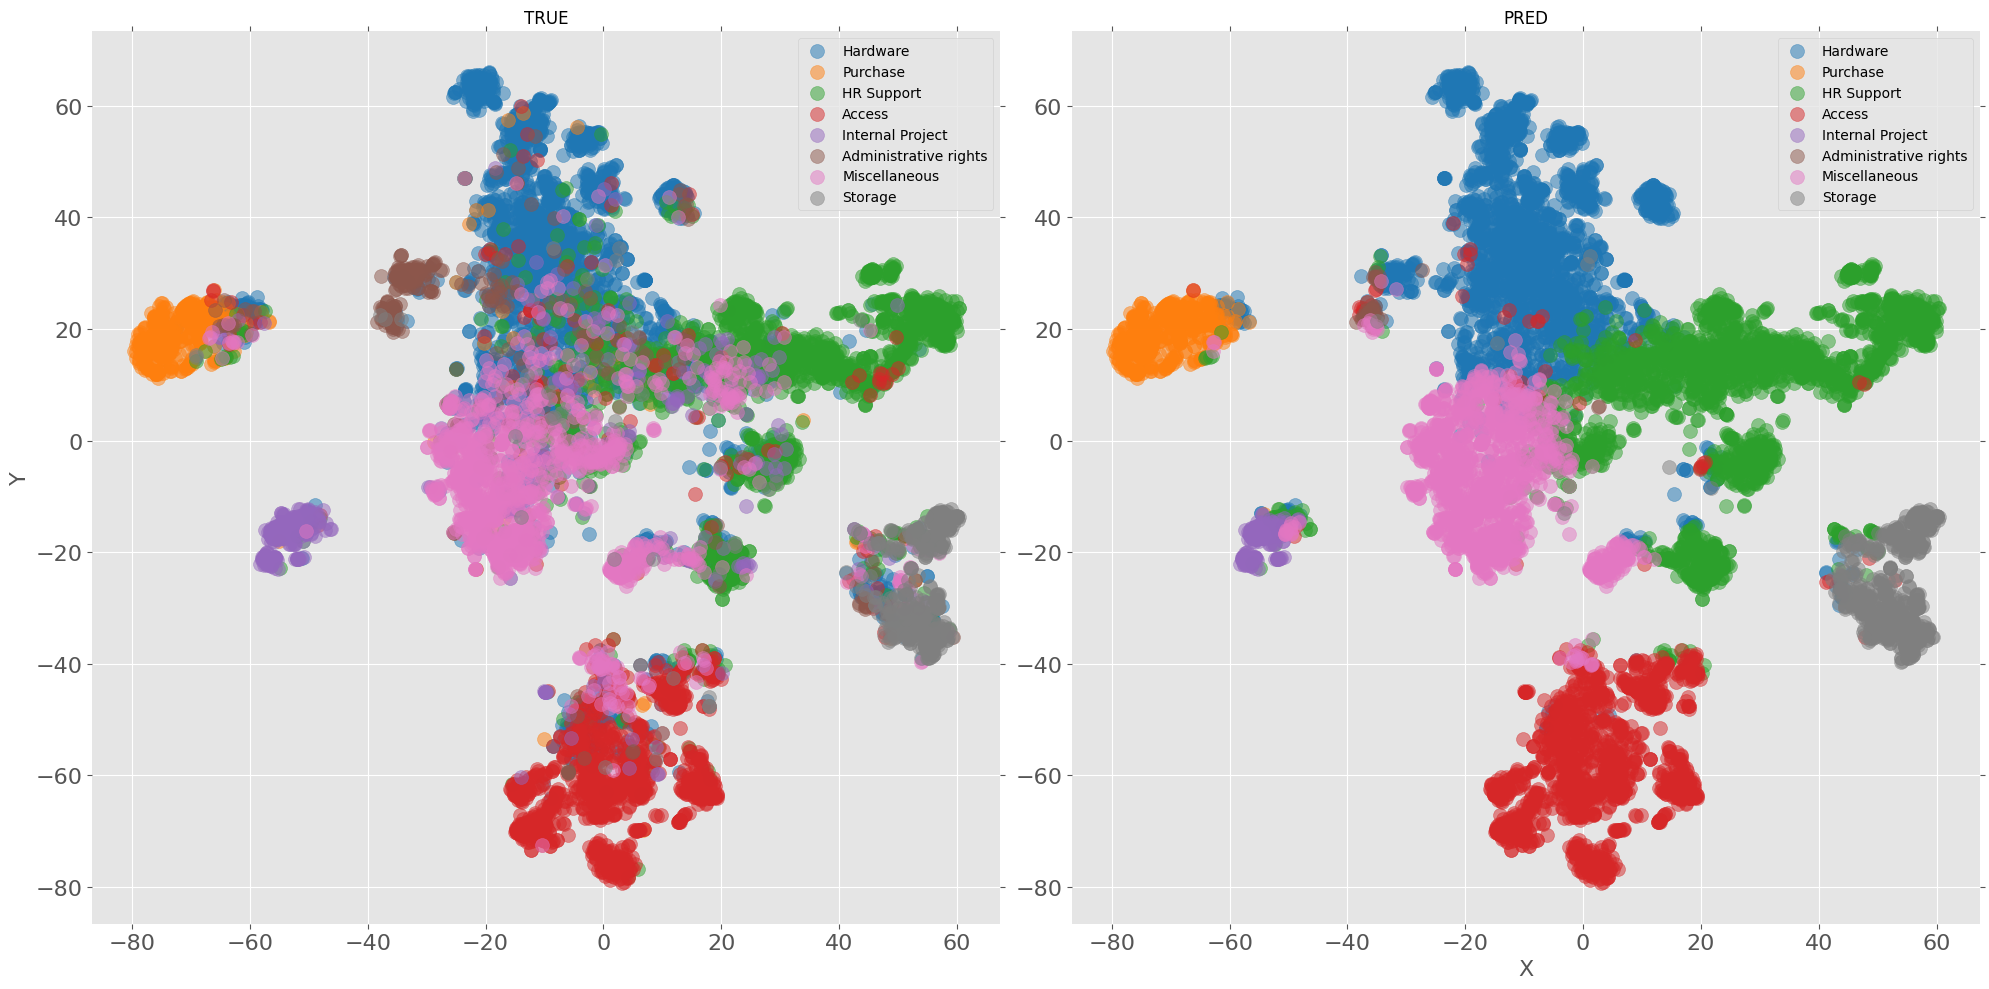

In [ ]:
mpl_fig, ax = plt.subplots(1,2,figsize = (20,10))

size = 100
alpha = 0.5
fontsize = 16


colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
]


for i,label in enumerate(df_plot['label'].unique()):
    df_plot_filter= df_plot[df_plot['label'] == label].copy()
    ax[0].scatter(df_plot_filter['x'], df_plot_filter['y'], c=colors[i], alpha=alpha, s=size, label = label)

for i,label in enumerate(df_plot['label'].unique()):
    df_plot_filter= df_plot[df_plot['pred'] == label].copy()
    ax[1].scatter(df_plot_filter['x'], df_plot_filter['y'], c=colors[i], alpha=alpha, s=size, label = label)

ax[0].legend(fontsize=10)
ax[1].legend(fontsize=10)

ax[0].set_title('TRUE',fontsize=12)
ax[1].set_title('PRED',fontsize=12)

# Turn off square border around plot.
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)

# Turn off ticks.
ax[0].tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on",
               labelsize=16)

ax[1].tick_params(axis="both", which="both", bottom="off", top="off",
               labelbottom="on", left="off", right="off", labelleft="on",
               labelsize=16)

ax[0].set_ylabel('Y', fontsize=fontsize)
ax[1].set_xlabel('X', fontsize=fontsize)

ax[0].set_ylabel('Y', fontsize=fontsize)
ax[1].set_xlabel('X', fontsize=fontsize)
plt.tight_layout()
plt.show()

# py.iplot_mpl(mpl_fig, filename='baltimore-poverty')

# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Thanks for Reading</p>